In [1]:
import numpy as np
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import seaborn as sns

In [2]:
np.random.seed(42)

In [3]:
def mutual_information_multivariate(X, Y):
    # Converting rows into strings to represent joint states
    X_encoded = [tuple(row) for row in X]
    Y_encoded = list(Y)

    joint_counts = Counter(zip(X_encoded, Y_encoded))
    total = len(X_encoded)

    joint_probs = {k: v / total for k, v in joint_counts.items()}
    X_counts = Counter(X_encoded)
    Y_counts = Counter(Y_encoded)

    X_probs = {k: v / total for k, v in X_counts.items()}
    Y_probs = {k: v / total for k, v in Y_counts.items()}

    mi = 0.0
    for (x, y), p_xy in joint_probs.items():
        p_x = X_probs[x]
        p_y = Y_probs[y]
        mi += p_xy * np.log(p_xy / (p_x * p_y))
        
    return mi / np.log(2)


In [4]:
# Jackknife resampling for mutual information
def jackknife_mi(X, Y, mutual_information_multivariate):
    n = len(X)
    mi_values = []

    for i in range(n):
        # Removing i-th sample
        X_jack = np.delete(X, i, axis=0)  # keeping 2D
        Y_jack = np.delete(Y, i, axis=0 if len(Y.shape) > 1 else None)

        # Computing MI on the reduced dataset
        mi_jack = mutual_information_multivariate(X_jack, Y_jack)
        mi_values.append(mi_jack)

    mi_jackknife = np.mean(mi_values)
    mi_variance = (n - 1) * np.var(mi_values)
    
    return mi_jackknife, mi_variance

In [ ]:
# testing on obvious strong depedencies
X1 = np.random.randint(0, 5, size=200)
X2 = X1.copy()
Y_obv = X1 + X2  # Y is fully determined by X1 and X2
X_obv = np.column_stack([X1, X2])

mi_val_obv = mutual_information_multivariate(X_obv, Y_obv)
mi_jk, var_jk = jackknife_mi(X_obv, Y_obv, mutual_information_multivariate)

print(f"Multivariate MI: {mi_val_obv:.4f}")
print(f"Jackknife MI Estimate: {mi_jk:.4f}, Variance: {var_jk:.6f}")

Multivariate MI: 2.3074
Jackknife MI Estimate: 2.3074, Variance: 0.000205


MI is high, ≈2.3, which reflects strong dependency (since Y = X1 + X2).

In [ ]:
# Generating multivariate dependencies
def generate_multivariate_data(n):
    X1 = np.random.randint(0, 3, size=n)
    X2 = X1 + np.random.randint(0, 2, size=n)  # Dependent feature
    Y1 = X1 + X2 + np.random.randint(0, 2, size=n)  # Output depends on both X1 and X2 and some noise
    return np.column_stack([X1, X2]), Y1  # Return Y1 as 1D array


X, Y = generate_multivariate_data(200)

mi_val = mutual_information_multivariate(X, Y)
mi_jack, var_jack = jackknife_mi(X, Y, mutual_information_multivariate)

print(f"Multivariate MI: {mi_val:.4f}")
print(f"Jackknife MI Estimate: {mi_jack:.4f}, Variance: {var_jack:.6f}")


Multivariate MI: 1.7338
Jackknife MI Estimate: 1.7338, Variance: 0.000784


In [6]:
# independent data
def generate_independent_data(n):
    X1 = np.random.randint(0, 5, size=n)
    X2 = np.random.randint(0, 5, size=n)
    Y1 = np.random.randint(0, 5, size=n)  # Y is independent of X1 and X2
    return np.column_stack([X1, X2]), Y1

X_indep, Y_indep = generate_independent_data(200)

mi_val_indep = mutual_information_multivariate(X_indep, Y_indep)
mi_jack_indep, var_jack_indep = jackknife_mi(X_indep, Y_indep, mutual_information_multivariate)

print(f"Independent Data MI: {mi_val_indep:.4f}")
print(f"Jackknife MI Estimate: {mi_jack_indep:.4f}, Variance: {var_jack_indep:.6f}")


Independent Data MI: 0.4210
Jackknife MI Estimate: 0.4233, Variance: 0.006760


From above, we got high value of MI for independent variables. Further testing it for different sample size to check if the MI value could be due to the sample size.

In [7]:
sample_sizes = [100, 200, 500, 1000, 2000]

for n in sample_sizes:
    X, Y = generate_independent_data(n)
    mi = mutual_information_multivariate(X, Y)
    mi_jk, var_jk = jackknife_mi(X, Y, mutual_information_multivariate)
    print(f"n={n:<5} | MI: {mi:.4f} | Jackknife MI: {mi_jk:.4f} | Variance: {var_jk:.6f}")


n=100   | MI: 0.7573 | Jackknife MI: 0.7636 | Variance: 0.011617
n=200   | MI: 0.4238 | Jackknife MI: 0.4259 | Variance: 0.004826
n=500   | MI: 0.1467 | Jackknife MI: 0.1471 | Variance: 0.001015
n=1000  | MI: 0.0640 | Jackknife MI: 0.0641 | Variance: 0.000201
n=2000  | MI: 0.0318 | Jackknife MI: 0.0318 | Variance: 0.000047


In [8]:
def average_mi_over_trials(n, trials=10):
    mi_vals = []
    mi_jk_vals = []
    for _ in range(trials):
        X, Y = generate_independent_data(n)
        mi = mutual_information_multivariate(X, Y)
        mi_jk, _ = jackknife_mi(X, Y, mutual_information_multivariate)
        mi_vals.append(mi)
        mi_jk_vals.append(mi_jk)
    return np.mean(mi_vals), np.mean(mi_jk_vals)

mi_avg, mi_jk_avg = average_mi_over_trials(200)
print(f"Averaged over 10 trials (n=200): MI = {mi_avg:.4f}, Jackknife MI = {mi_jk_avg:.4f}")


Averaged over 10 trials (n=200): MI = 0.4441, Jackknife MI = 0.4463


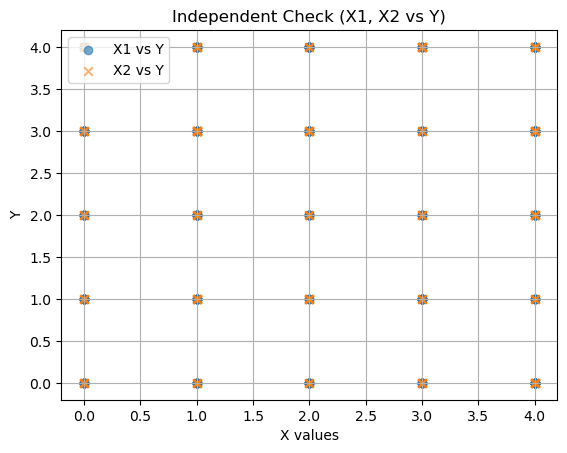

In [9]:
import matplotlib.pyplot as plt

X, Y = generate_independent_data(200)
plt.scatter(X[:, 0], Y, alpha=0.6, label='X1 vs Y')
plt.scatter(X[:, 1], Y, alpha=0.6, label='X2 vs Y', marker='x')
plt.title("Independent Check (X1, X2 vs Y)")
plt.legend()
plt.xlabel("X values")
plt.ylabel("Y")
plt.grid(True)
plt.show()


When testing with different sample sizes, we observed that the MI values decreased as the sample size increased.

For small samples (e.g., 100–200), the MI was relatively high (~0.4–0.7) due to noise and estimation bias. As the sample size grew (500, 1000, 2000), the MI estimates became much smaller (~0.03–0.15), approaching the expected value of zero for independent data.

The jackknife MI estimates closely matched the original MI estimates in all cases but provided a variance estimate, showing uncertainty at smaller sample sizes and stabilizing as more data was used.

Mutual information estimates for independent variables are biased upward when data is limited, but the bias reduces with larger datasets. The jackknife method helps quantify the variability in the MI estimate but does not fundamentally correct the bias alone.

In the case of independent data, MI should ideally be close to zero, but because there is some inherent randomness in the data and the estimation process, we see a non-zero value (0.4210). This could be due to the finite sample size and the way mutual information is computed.

In [ ]:
# weak dependency
def generate_weak_dependency_data(n):
    X1 = np.random.randint(0, 5, size=n)
    X2 = X1 + np.random.randint(0, 1, size=n)  # Weak dependency between X1 and X2
    Y1 = X1 + np.random.randint(0, 3, size=n)  # Y depends only weakly on X1
    return np.column_stack([X1, X2]), Y1

X_weak, Y_weak = generate_weak_dependency_data(200)

mi_val_weak = mutual_information_multivariate(X_weak, Y_weak)
mi_jack_weak, var_jack_weak = jackknife_mi(X_weak, Y_weak, mutual_information_multivariate)

print(f"Weak Dependency MI: {mi_val_weak:.4f}")
print(f"Jackknife MI Estimate: {mi_jack_weak:.4f}, Variance: {var_jack_weak:.6f}")


Weak Dependency MI: 1.1057
Jackknife MI Estimate: 1.1058, Variance: 0.001568


For weak dependency, the MI is higher than for independent data, as expected. The Jackknife estimate is almost identical to the MI, and the variance is low.

In [ ]:
# non-linear dependencies
def generate_nonlinear_data(n):
    X1 = np.random.randint(0, 5, size=n)
    X2 = np.random.randint(0, 5, size=n)
    Y1 = np.sin(X1) + np.log(X2 + 1) + np.random.randint(0, 3, size=n)  # Non-linear relation
    return np.column_stack([X1, X2]), Y1

X_nonlinear, Y_nonlinear = generate_nonlinear_data(200)

mi_val_nonlinear = mutual_information_multivariate(X_nonlinear, Y_nonlinear)
mi_jack_nonlinear, var_jack_nonlinear = jackknife_mi(X_nonlinear, Y_nonlinear, mutual_information_multivariate)

print(f"Non-linear MI: {mi_val_nonlinear:.4f}")
print(f"Jackknife MI Estimate: {mi_jack_nonlinear:.4f}, Variance: {var_jack_nonlinear:.6f}")


Non-linear MI: 4.5754
Jackknife MI Estimate: 4.5750, Variance: 0.001061


In the non-linear case, MI is higher, reflecting the more complex relationships between the variables.

In [ ]:
# noisy linear dependencies
def generate_noisy_linear_data(n):
    X1 = np.random.randint(0, 5, size=n)
    X2 = 2 * X1 + np.random.randint(0, 3, size=n)  # X2 is noisy version of X1
    Y1 = X1 + X2 + np.random.randint(0, 5, size=n)  # Y depends linearly on X1 and X2, but with noise
    return np.column_stack([X1, X2]), Y1

X_noisy, Y_noisy = generate_noisy_linear_data(200)

mi_val_noisy = mutual_information_multivariate(X_noisy, Y_noisy)
mi_jack_noisy, var_jack_noisy = jackknife_mi(X_noisy, Y_noisy, mutual_information_multivariate)

print(f"Noisy Linear MI: {mi_val_noisy:.4f}")
print(f"Jackknife MI Estimate: {mi_jack_noisy:.4f}, Variance: {var_jack_noisy:.6f}")


Noisy Linear MI: 1.9840
Jackknife MI Estimate: 1.9850, Variance: 0.004710


For noisy linear dependencies, the MI is slightly lower than for non-linear cases due to the added noise.